# All classes detections using OTB preprecessed channels with basic unet network

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import sys
sys.path.append("../common/")

import cv2
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS, TRAIN_DATA, TRAIN_LABEL_TILES
from image_utils import get_image_data, get_image_tile_data, normalize
from visu_utils import display_img_1b, display_labels, plt_st

### Input data

In [4]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [5]:
from glob import glob
all_train_ids = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_ids = np.array([s[len(TRAIN_DATA)+1:-4] for s in all_train_ids if 'mean' not in s and 'std' not in s])
print "First & last train ids : ", all_train_ids[0], all_train_ids[-1], len(all_train_ids)

First & last train ids :  6010_1_2 6170_4_1 25


In [6]:
from image_utils import imwrite, compute_mean_std_on_images
from geo_utils.GeoImage import GeoImage

ll = int(len(all_train_ids)*0.8)
train_ids = all_train_ids[:ll]
val_ids = all_train_ids[ll:]


feature_wise = True
s = ''
out_shape = (3500, 3500, 17)
if feature_wise:
    s = "_feature_wise"

mean_fname = os.path.join(TRAIN_DATA, 'mean_image%s.tif' % s)
std_fname = os.path.join(TRAIN_DATA, 'std_image%s.tif' % s)
if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
    logging.getLogger().setLevel(logging.INFO)
    mean_image, std_image = compute_mean_std_on_images(train_ids, 'input', feature_wise=feature_wise, out_shape=out_shape)
    logging.getLogger().setLevel(logging.ERROR)
    imwrite(mean_fname, mean_image)
    imwrite(std_fname, std_image)
else:
    mean_image = GeoImage(mean_fname).get_data()
    std_image = GeoImage(std_fname).get_data()

print mean_image.shape, std_image.shape
print mean_image.min(), mean_image.max(), std_image.min(), std_image.max()
print len(train_ids), len(val_ids)

logging.getLogger().setLevel(logging.ERROR)

No handlers could be found for logger "geo_utils.GeoImage"


(3349L, 3404L, 17L) (3349L, 3404L, 17L)
-21597.8 1900.22 0.0 94449.1
20 5


In [7]:
from data_utils import get_image_ids
from training_utils import tile_iterator, get_XY_val

# def normalize_image(img_data, mean_image=None, std_image=None):
#     out = img_data.astype(np.float32)    
#     if mean_image is not None or std_image is not None:
#         out -= mean_image 
#         out /= std_image
#     out = out.transpose([2,0,1])
#     return out

def generate_images(image_ids_to_use, batch_size, resolution_level=1):
    while True:
        X = np.zeros((batch_size, n_channels)+tile_size, dtype=np.float32)
        Y = np.zeros((batch_size, n_labels)+tile_size, dtype=np.float32)
        tiles = tile_iterator(image_ids_to_use,
                              channels,
                              labels, 
                              presence_percentage=10, 
                              tile_size=tile_size, 
                              mean_image=mean_image,
                              std_image=std_image,
                              resolution_levels=(resolution_level,)
                             )
        counter = 0
        for x, y in tiles:     
            
            x = x.transpose([2,0,1])
            y = y.transpose([2,0,1])

            X[counter,:,:,:] = x
            Y[counter,:,:,:] = y 
            counter += 1
            if counter == batch_size:
                yield (X, Y)
                counter = 0


Training class groups : number of pixels x appearence frequency ~ probability that a pixel of the image is of a class

1. `Buildings` and `Misc. Manmade structures` and `Track` : [1, 2, 4]
2. `Standing water` and `Road` and `Waterway` : [8, 3, 7]
3. `Trees` and `Crops`: [5, 6]
4. `Vehicle Small` : [10]
5. `Vehicle Large` : [9]


In [8]:
shape = get_image_data(TRAIN_IMAGE_IDS[0], 'input', return_shape_only=True)

tile_size = (256, 256)
channels = np.array(range(shape[2]))
# channels = np.array([0, 1, 2, 3, 4])
n_channels = len(channels)

labels = np.array(range(1,len(LABELS)))
#labels = np.array([5, 6])
n_labels = len(labels)

In [9]:
channels, labels

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

(5, 17, 256, 256) (5, 10, 256, 256)
-5.50102 14.77 0.0 1.0


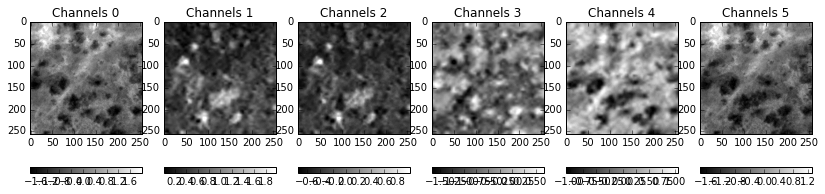

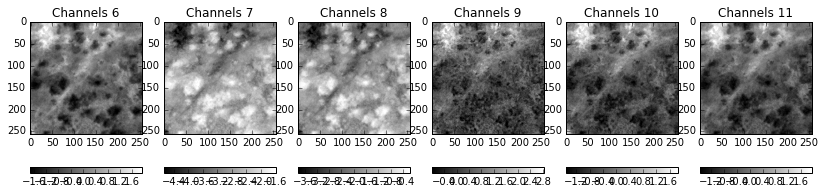

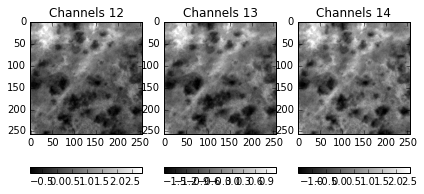

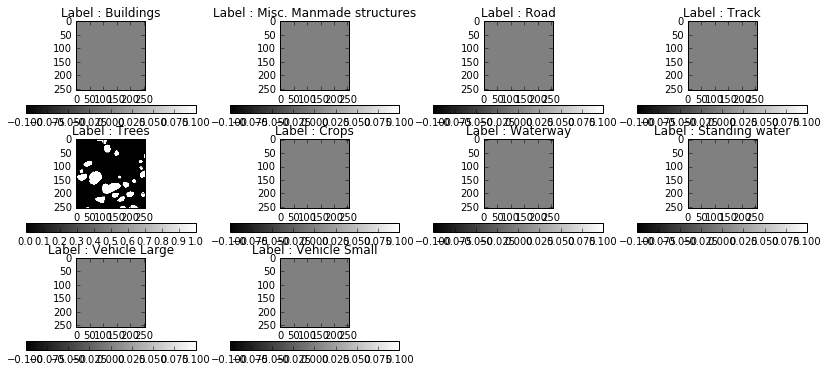

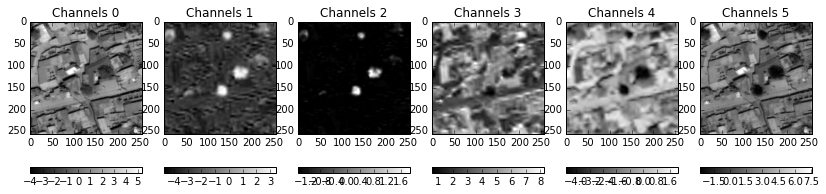

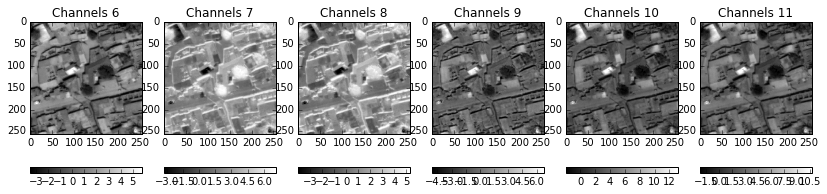

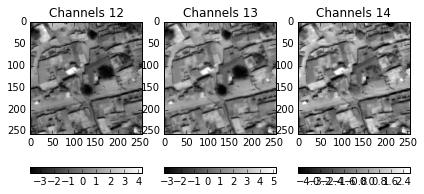

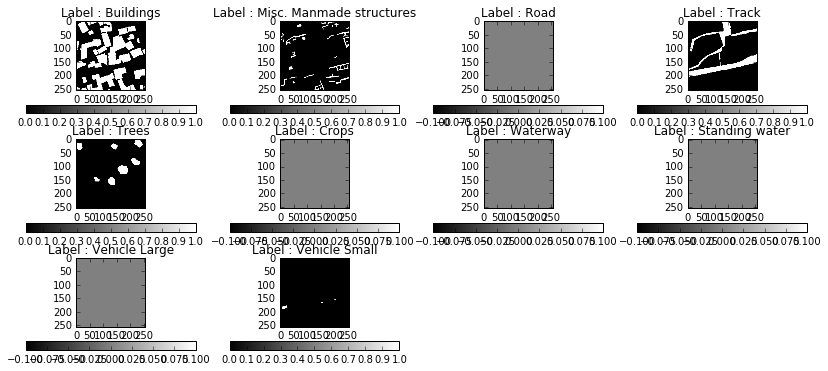

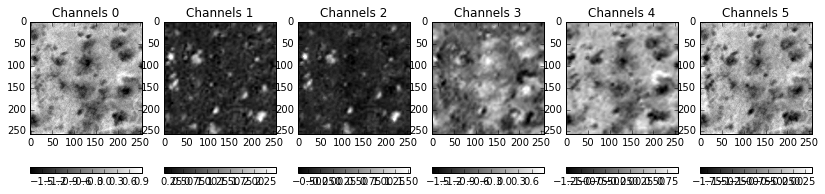

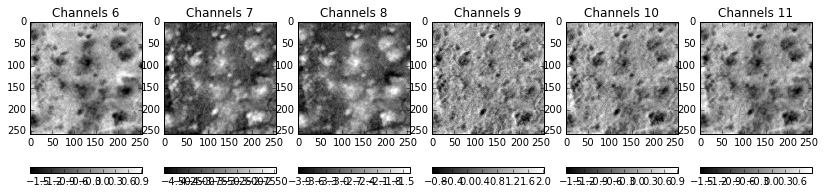

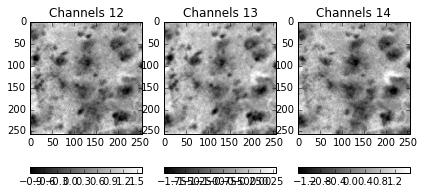

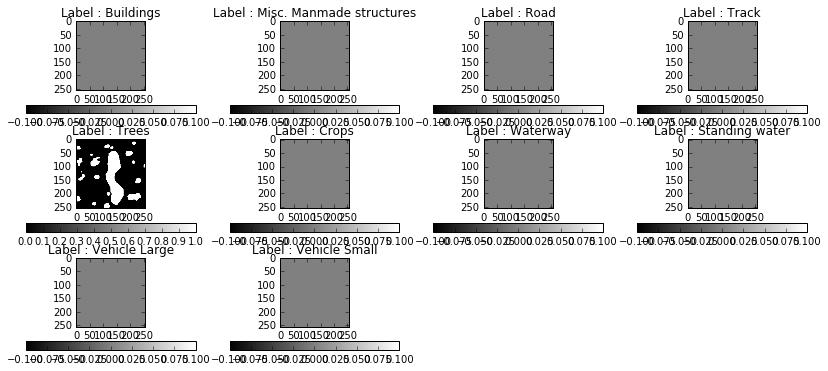

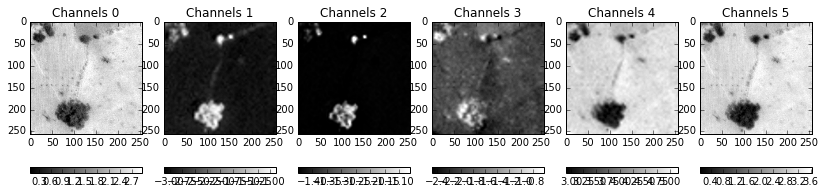

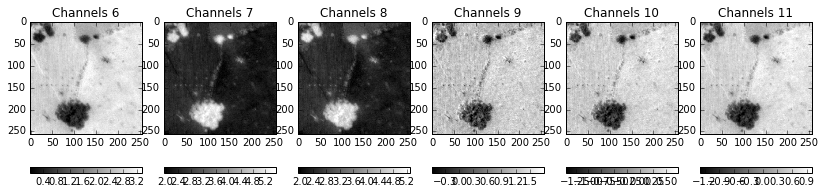

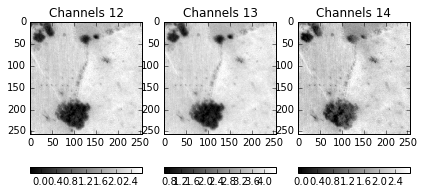

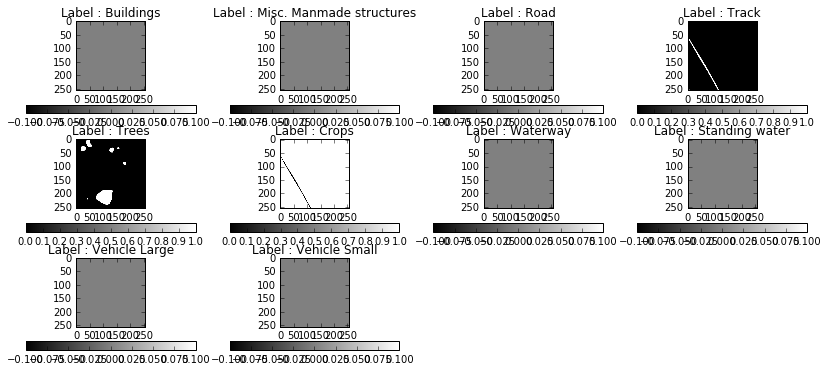

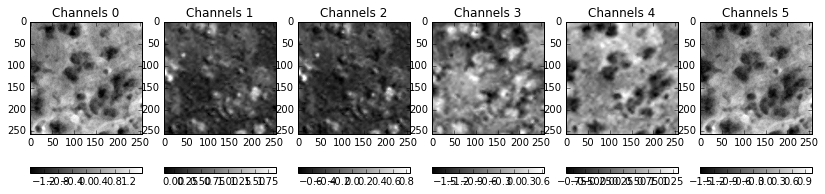

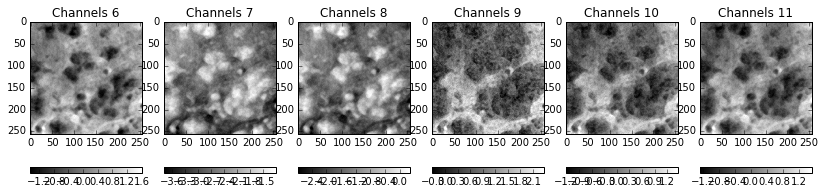

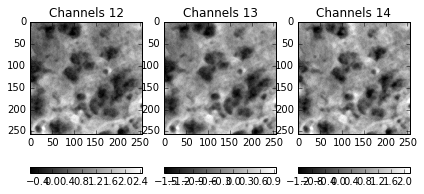

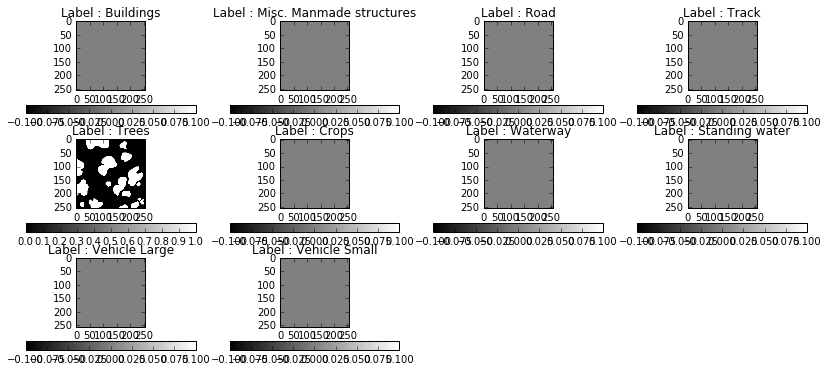

In [12]:
batch_size = 5
for X, Y in generate_images(train_ids, batch_size):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    _channels = min(15, n_channels)
    for i in range(batch_size):
        
        n, m = 3, int(_channels * 1.0 / 3.0 + 1.0)
        for j in range(_channels):
            if j % m == 0:
                plt.figure(figsize=(14, 4))                
            plt.subplot(1,m,j % m +1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if n_labels < 8:
            n, m = 1, n_labels
        else:
            n, m = 3, int(n_labels * 1.0 / 3.0 + 1.0), 
        for j in range(n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [10]:
# X_val, Y_val = get_XY_val(val_ids, channels, labels, mean_image=mean_image, std_image=std_image)

In [11]:
# print X_val.shape, X_val.dtype
# print [(X_val[b,:,:,:].min(), X_val[b,:,:,:].max()) for b in range(X_val.shape[0])]
# print Y_val.shape, Y_val.dtype
# print [(Y_val[b,:,:,:].min(), Y_val[b,:,:,:].max()) for b in range(X_val.shape[0])]

In [12]:
# for i in range(X_val.shape[0]):
#     _channels = X_val.shape[1]
#     n, m = 3, int(_channels * 1.0 / 3.0 + 1.0)
#     for j in range(_channels):
#         if j % m == 0:
#             plt.figure(figsize=(14, 4))                
#         plt.subplot(1,m,j % m +1)
#         display_img_1b(X_val[i,j,:,:])
#         plt.title("Channels %i" % j)

#     plt.figure(figsize=(14, 6))    
#     if n_labels < 8:
#         n, m = 1, n_labels
#     else:
#         n, m = 3, int(n_labels * 1.0 / 3.0 + 1.0), 
#     for j in range(n_labels):
#         plt.subplot(n, m,j+1)
#         display_img_1b(Y_val[i,j,:,:])
#         plt.title("Label : %s" % LABELS[labels[j]])


In [13]:
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

from another_unet import unet

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5110)


In [14]:
model = unet(n_labels, n_channels, *tile_size)
weights_filename = os.path.join("weights", "another_unet_%i_%i.h5" % (n_channels, n_labels))

In [15]:
if os.path.exists(weights_filename):
    print "Found weights file %s" % weights_filename
    model.load_weights(weights_filename)

Found weights file weights\another_unet_17_10.h5


In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 17, 256, 256)  0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 128, 128)  9856        input_1[0][0]                    
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 64, 128, 128)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 128, 64, 64)   73856       leakyrelu_1[0][0]                
___________________________________________________________________________________________

In [86]:
# serialize model to JSON
model_filename = os.path.join("another_unet_%i_%i.json" % (n_channels, n_labels))
model_json = model.to_json()
with open(model_filename, "w") as json_file:
    json_file.write(model_json)

In [22]:
# from cgt_callbacks import CalcJaccard

if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)
#earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)

# cgt_calc_jaccard = CalcJaccard(X_val, Y_val)

# LearningRateScheduler

In [23]:
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'recall', 'precision'])

In the neural network terminology:

- one epoch = one forward pass and one backward pass of all the training examples
    
- batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
    
- number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

In [29]:
# foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 4
samples_per_epoch = 1024
nb_val_samples = 256


print batch_size, samples_per_epoch, nb_val_samples
try:
    history = model.fit_generator(
        generate_images(train_ids, batch_size),
        samples_per_epoch=samples_per_epoch, 
        nb_epoch=50,
        validation_data=generate_images(val_ids, batch_size),
        nb_val_samples=nb_val_samples,
        callbacks=[model_checkpoint],
        verbose=2
    )
except KeyboardInterrupt:    
    model.save_weights(weights_filename)


4 1024 256
Epoch 1/50
270s - loss: 0.0876 - jaccard_coef: 0.1399 - jaccard_coef_int: 0.1296 - recall: 0.4259 - precision: 0.7277 - val_loss: 0.1686 - val_jaccard_coef: 0.0384 - val_jaccard_coef_int: 0.0337 - val_recall: 0.2353 - val_precision: 0.3394
Epoch 2/50
248s - loss: 0.0769 - jaccard_coef: 0.1355 - jaccard_coef_int: 0.1284 - recall: 0.4158 - precision: 0.7115 - val_loss: 0.1378 - val_jaccard_coef: 0.0388 - val_jaccard_coef_int: 0.0347 - val_recall: 0.2066 - val_precision: 0.3529
Epoch 3/50
272s - loss: 0.0797 - jaccard_coef: 0.1497 - jaccard_coef_int: 0.1441 - recall: 0.4571 - precision: 0.7309 - val_loss: 0.1398 - val_jaccard_coef: 0.0341 - val_jaccard_coef_int: 0.0284 - val_recall: 0.1849 - val_precision: 0.3246
Epoch 4/50
217s - loss: 0.0770 - jaccard_coef: 0.1314 - jaccard_coef_int: 0.1241 - recall: 0.4201 - precision: 0.7217 - val_loss: 0.1165 - val_jaccard_coef: 0.0392 - val_jaccard_coef_int: 0.0332 - val_recall: 0.2079 - val_precision: 0.5052
Epoch 5/50
267s - loss: 0.089

In [15]:
# plt.plot(history.history['val_jaccard_coef_int'])
# plt.ylabel('Jaccard coeff integer')
plt.plot(history.history['val_jaccard_coef'])
plt.ylabel('Jaccard coeff')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

(5, 10, 256, 256) 1.11999e-26 0.999979


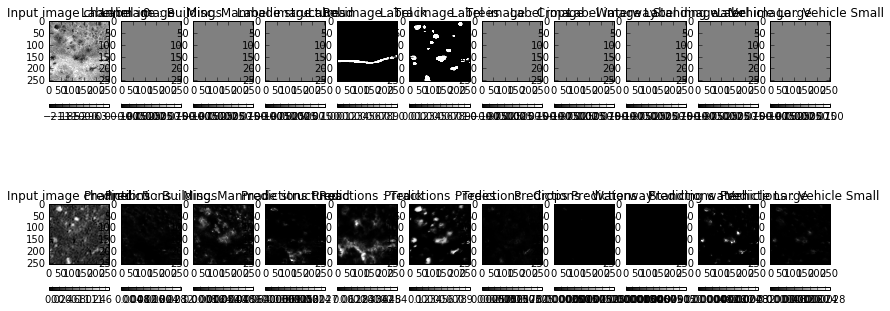

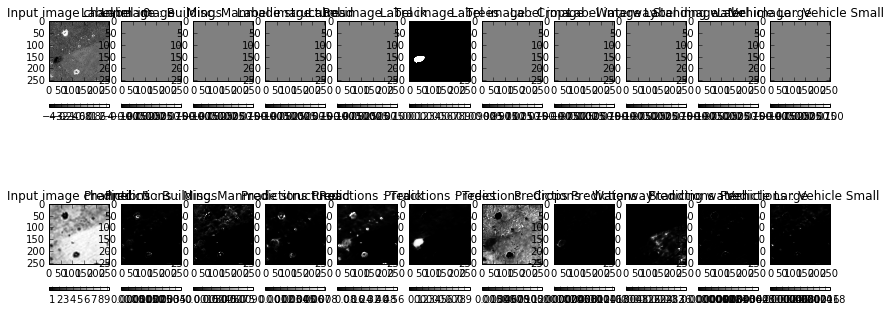

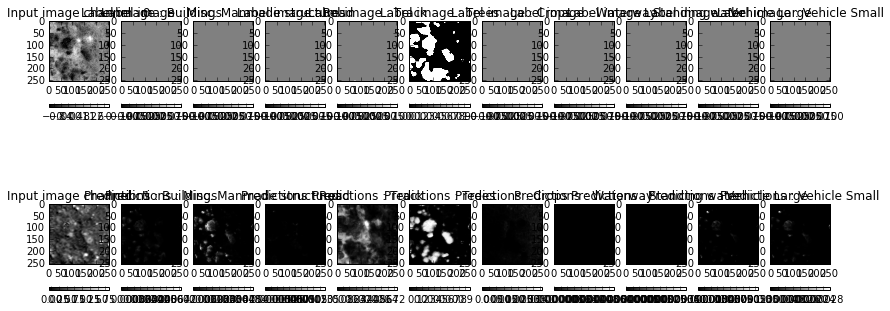

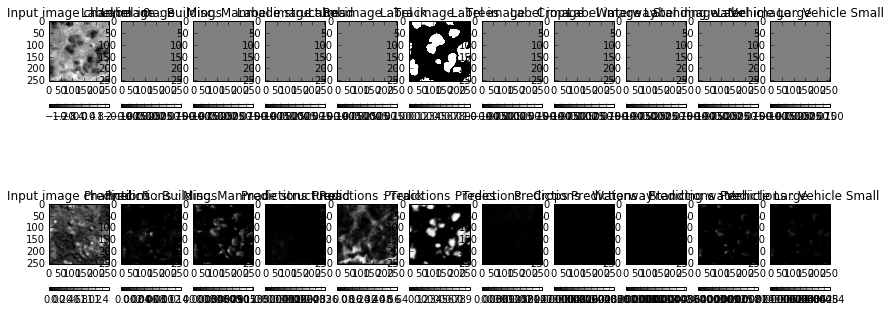

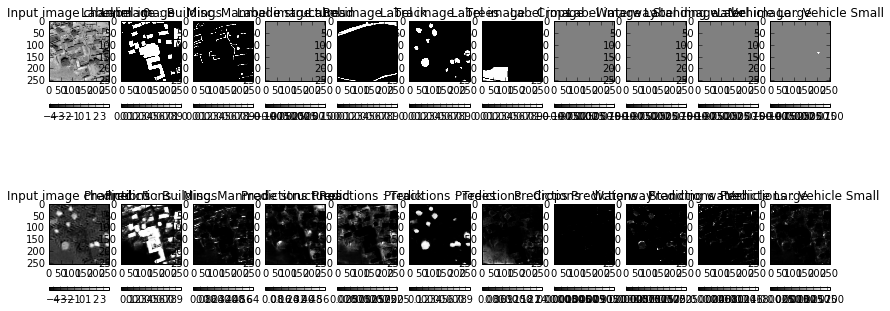

In [24]:
batch_size = 5

for X, Y in generate_images(train_ids, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break

In [25]:
# from cgt_callbacks import calc_jacc
# score, trs = calc_jacc(model, img=X_val, msk=Y_val, range_thres=range(5, 10), batch_size=4)
# print score, trs

ValueError: Error when checking : expected input_1 to have shape (None, 17, 256, 256) but got array with shape (5, 17, 3348, 3403)

Prediction part

In [25]:
from predictions_utils import compute_predictions

In [26]:
def decision_func(img_pred):
    out = img_pred.copy()
    out[out < 0.5] = 0.0
    out[out >= 0.5] = 1.0
    return out.astype(np.uint8)

In [27]:
def score(y_true, y_pred):
    smooth = 1e-12
    intersection = np.sum(y_true * y_pred, axis=(0, 1))
    sum_ = np.sum(y_true + y_pred, axis=(0, 1))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return np.mean(jac)

Validation total score

In [ ]:
validation_score = 0
for image_id in val_ids:
    Y_predictions = compute_predictions(image_id, model, mean_image, std_image)
    labels_image = get_image_data(image_id, 'label')
    h, w, _ = labels_image.shape
    s = score(labels_image[:,:,1:], decision_func(Y_predictions[:h,:w,:]))
    print "-- score :", image_id, s
    validation_score += s
validation_score *= 1.0/len(val_ids)
print "Validation score :", validation_score

-- score : 6150_2_3 0.453408482398


~30

-- score : 6150_2_3 0.515055223125
-- score : 6160_2_1 0.407795750234
-- score : 6170_0_4 0.33183100544
-- score : 6170_2_4 0.446790314564
-- score : 6170_4_1 0.533762181162
Validation score : 0.447046894905

~40

-- score : 6150_2_3 0.412640360964
-- score : 6160_2_1 0.325404555786
-- score : 6170_0_4 0.444145018395
-- score : 6170_2_4 0.442513305571
-- score : 6170_4_1 0.541120544379
Validation score : 0.433164757019

~ 80




In [58]:
img_pan = get_image_data(image_id, 'pan')

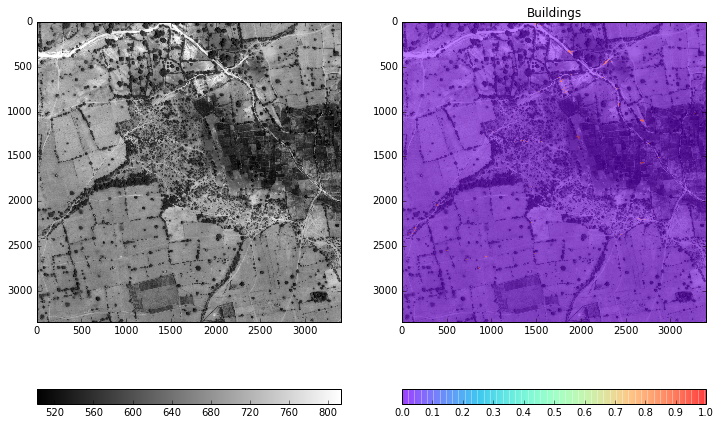

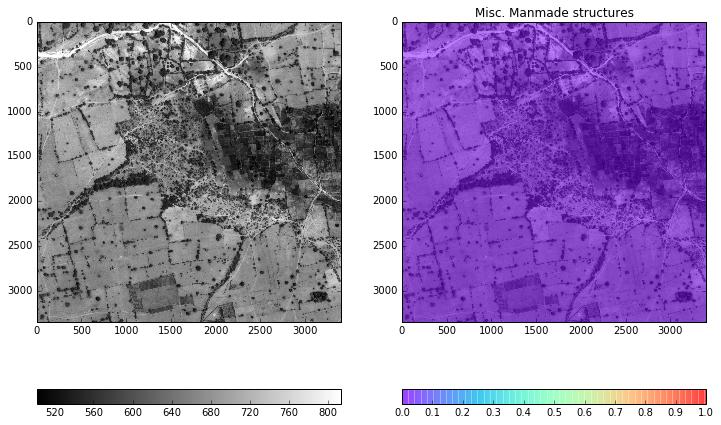

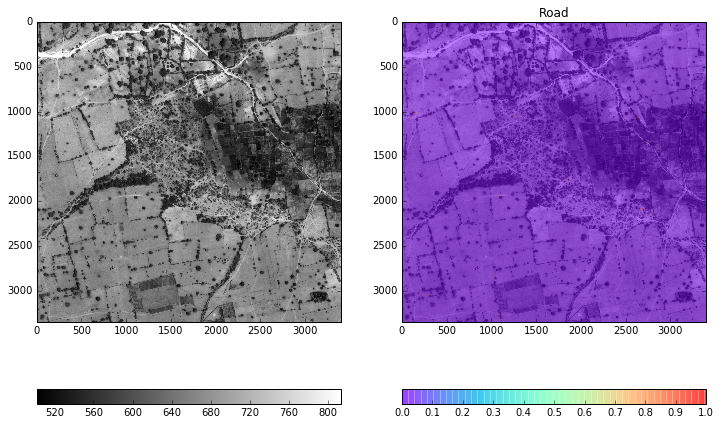

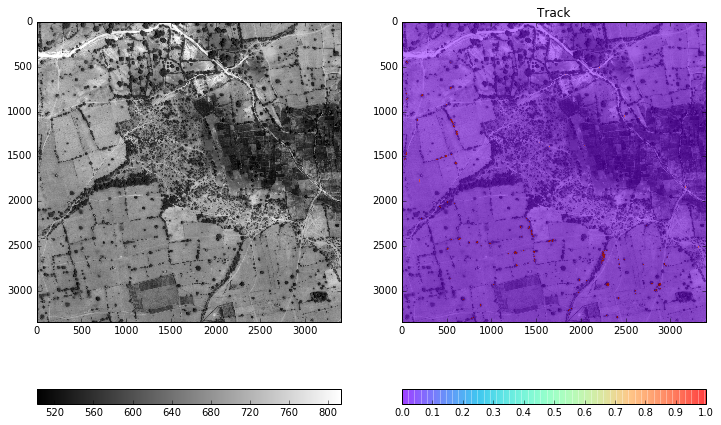

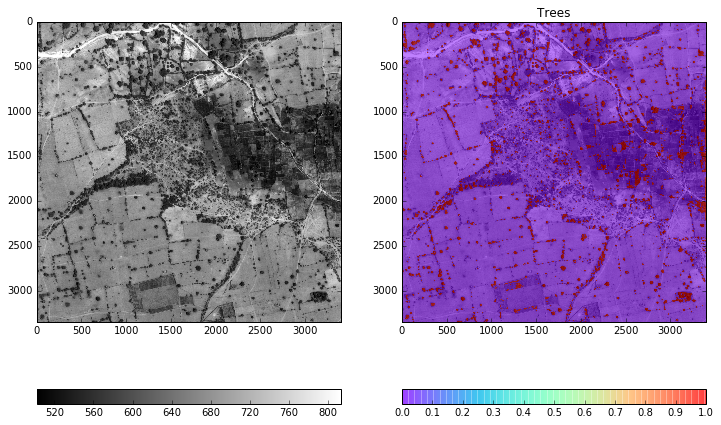

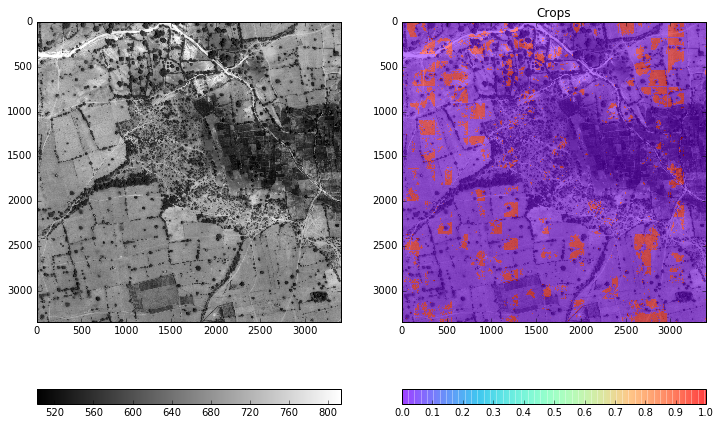

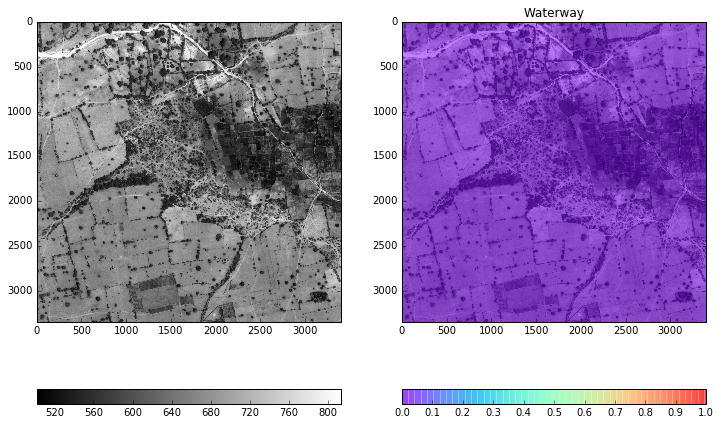

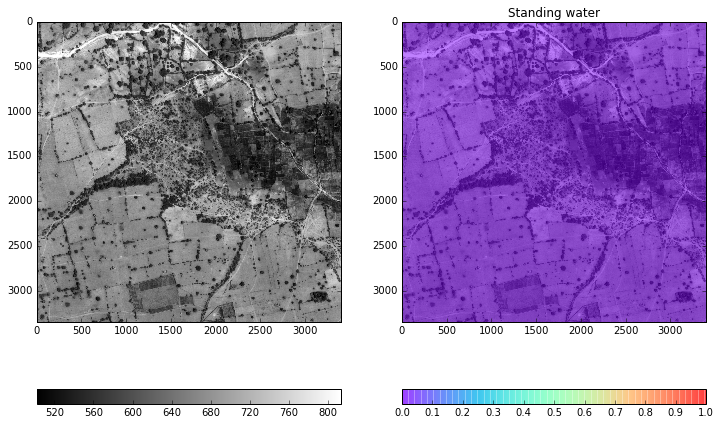

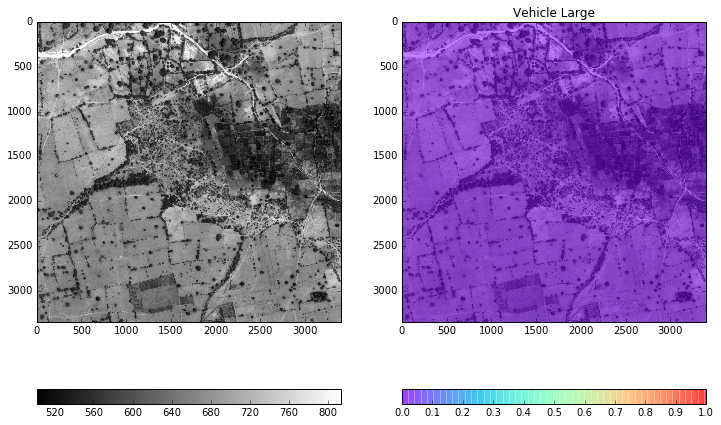

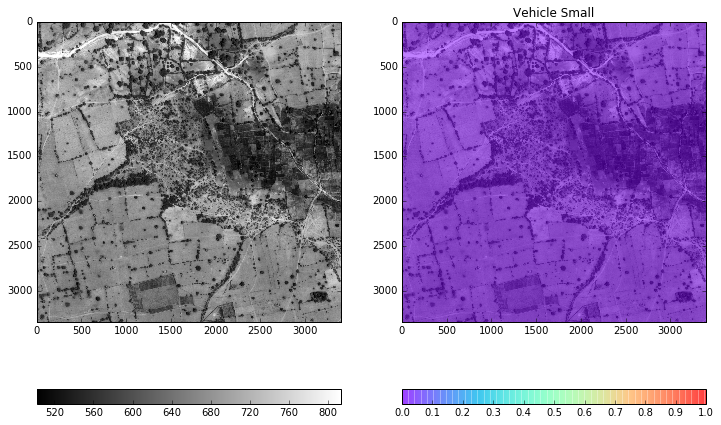

In [62]:
roi = [0, 2000, 500, 2500]
roi = None
ll = Y_predictions.shape[0]
for i in range(ll):
    plt_st(12,8)
    plt.subplot(121)
    display_img_1b(img_pan, roi)
    plt.subplot(122)
    plt.title("%s" % LABELS[i+1])
    display_img_1b(img_pan, roi, no_colorbar=True)
    display_img_1b(decision_func(Y_predictions[i,:,:]), roi, alpha=0.5, cmap='rainbow', clim=[0, 1])
    

In [ ]:
labels_image = get_image_data(image_id, 'label')

In [83]:
print "Score : ", score(labels_image[:,:,1:], decision_func(Y_predictions))

Score :  0.446476584985


In [34]:
mean_image.shape

(3500, 3500, 17)

In [35]:
image_id = "6080_2_4"
Y_predictions = compute_predictions(image_id, model, mean_image, std_image)

0 0 0 (256, 256)
1 181 0 (256, 256)
2 362 0 (256, 256)
3 544 0 (256, 256)
0 725 0 (256, 256)
1 906 0 (256, 256)
2 1087 0 (256, 256)
3 1268 0 (256, 256)
0 1449 0 (256, 256)
1 1631 0 (256, 256)
2 1812 0 (256, 256)
3 1993 0 (256, 256)
0 2174 0 (256, 256)
1 2355 0 (256, 256)
2 2536 0 (256, 256)
3 2718 0 (256, 256)
0 2899 0 (256, 256)
1 3080 0 (256, 256)
2 0 182 (256, 256)
3 181 182 (256, 256)
0 362 182 (256, 256)
1 544 182 (256, 256)
2 725 182 (256, 256)
3 906 182 (256, 256)
0 1087 182 (256, 256)
1 1268 182 (256, 256)
2 1449 182 (256, 256)
3 1631 182 (256, 256)
0 1812 182 (256, 256)
1 1993 182 (256, 256)
2 2174 182 (256, 256)
3 2355 182 (256, 256)
0 2536 182 (256, 256)
1 2718 182 (256, 256)
2 2899 182 (256, 256)
3 3080 182 (256, 256)
0 0 364 (256, 256)
1 181 364 (256, 256)
2 362 364 (256, 256)
3 544 364 (256, 256)
0 725 364 (256, 256)
1 906 364 (256, 256)
2 1087 364 (256, 256)
3 1268 364 (256, 256)
0 1449 364 (256, 256)
1 1631 364 (256, 256)
2 1812 364 (256, 256)
3 1993 364 (256, 256)
0 21